In [218]:
import os

data = "../../src/tools/data/schubert.md"
with open(data, "rt", encoding="utf-8") as fin:
	data = fin.read()

In [219]:
data = [e.strip() for e in data.split('#') if e.strip()]
len(data)

24

In [220]:
data

['Gute Nacht.\n\nFremd bin ich eingezogen,\nFremd zieh’ ich wieder aus.\nDer Mai war mir gewogen\nMit manchem Blumenstrauß.\nDas Mädchen sprach von Liebe,\nDie Mutter gar von Eh’ —\nNun ist die Welt so trübe,\nDer Weg gehüllt in Schnee.\n\nIch kann zu meiner Reisen\nNicht wählen mit der Zeit:\nMuß selbst den Weg mir weisen\nIn dieser Dunkelheit.\nEs zieht ein Mondenschatten\nAls mein Gefährte mit,\nUnd auf den weißen Matten\nSuch’ ich des Wildes Tritt.\n\nWas soll ich länger weilen,\nBis man mich trieb’ hinaus?\nLaß irre Hunde heulen\nVor ihres Herren Haus!\nDie Liebe liebt das Wandern, —\nGott hat sie so gemacht —\nVon Einem zu dem Andern —\nFein Liebchen, gute Nacht!\n\nWill dich im Traum nicht stören,\nWär’ Schad’ um deine Ruh’,\nSollst meinen Tritt nicht hören —\nSacht, sacht die Thüre zu!\nIch schreibe nur im Gehen\nAn’s Thor noch gute Nacht,\nDamit du mögest sehen,\nIch hab’ an dich gedacht.',
 'Die Wetterfahne.\n\nDer Wind spielt mit der Wetterfahne\nAuf meines schönen Liebchens

In [193]:
gpt_models = [
	"gpt-3.5-turbo", "gpt-4o-mini"
]
trainedness_s = [
	"untrained", "pretrained"
]

def get_annotator_name(gpt_model, trainedness, num=0):
	annotator_name = f"chatgpt_{gpt_model}-{trainedness}_{num}"
	return annotator_name

for gpt_model in gpt_models:
	for trainedness in trainedness_s:
		print(get_annotator_name(gpt_model, trainedness))

chatgpt_gpt-3.5-turbo-untrained_0
chatgpt_gpt-3.5-turbo-pretrained_0
chatgpt_gpt-4o-mini-untrained_0
chatgpt_gpt-4o-mini-pretrained_0


In [133]:
import requests
from pprint import pprint
import json

HOST = "http://127.0.0.1:56123"
API = "/api/v4"
BASE = HOST + API

res = requests.get(BASE+"/user/get-temp-user")
key = res.json()["key"]
headers = {"Authorization": f"Token {key}"}

def api(endpoint, method="GET", json=None):
	func = requests.get if method == "GET" else requests.post
	return func(BASE + endpoint, json=json, headers=headers)

In [230]:
import time

def test(original_text, gpt_models=gpt_models, trainedness_s=trainedness_s, num=0): #ad hoc...
	toret = {}

	res = api("/upload", "POST", json={"original_text": original_text})
	corpus_id = res.json()["corpus_id"]

	p_delim = "\\n\\n" #poems
	api("/parser/divide", "POST", json={
		"corpus_id": corpus_id,
		"divide_options": {
			"p_delims": [p_delim]
		},
	})
	res = api("/parser/parse", "POST", json={
		"corpus_id": corpus_id,
		"parse_options": {
			"t_delims": None,
		},
	})

	#Prepared
	#res = api(f"/corpuses/{corpus_id}")

	for gpt_model in gpt_models:
		for trainedness in trainedness_s:
			annotator_name = get_annotator_name(gpt_model, trainedness, num=num)
			print(annotator_name)

			start = time.time()
			
			res = api("/annotator/annotate", "POST", json={
				"corpus_id": corpus_id,
				"annotate_options": {
					"lang_from": "German", "lang_to": "English",
					"annotator_name": annotator_name,
					"target_paragraphs": None,
				}
			})
			elapsed = time.time() - start
			print(f"{elapsed : .2f}")

			#Check if it succeeded
			task_id = res.json()["task_id"]
			res = api(f"/tasks/{task_id}")
			assert res.json()["status"] == "FINISHED"

			res = api(f"/corpuses/{corpus_id}")
			corpus = res.json()["corpuses_history"][-1]
			gloss = []
			for p in corpus["paragraphs"]:
				for t in p["tokens"]:
					gloss.append(t["gloss"])
			ratio = len([e for e in gloss if e != "!UNKNOWN"]) / len(gloss)

			toret[annotator_name] = {"elapsed": elapsed, "ratio": ratio}
			print(toret)

	return toret

In [232]:
total = {}
for text in data:
	ret = test(text)
	total[text] = ret

chatgpt_gpt-3.5-turbo-untrained_0
 19.49
{'chatgpt_gpt-3.5-turbo-untrained_0': {'elapsed': 19.486268043518066, 'ratio': 1.0}}
chatgpt_gpt-3.5-turbo-pretrained_0
 20.97
{'chatgpt_gpt-3.5-turbo-untrained_0': {'elapsed': 19.486268043518066, 'ratio': 1.0}, 'chatgpt_gpt-3.5-turbo-pretrained_0': {'elapsed': 20.974897861480713, 'ratio': 1.0}}
chatgpt_gpt-4o-mini-untrained_0
 19.43
{'chatgpt_gpt-3.5-turbo-untrained_0': {'elapsed': 19.486268043518066, 'ratio': 1.0}, 'chatgpt_gpt-3.5-turbo-pretrained_0': {'elapsed': 20.974897861480713, 'ratio': 1.0}, 'chatgpt_gpt-4o-mini-untrained_0': {'elapsed': 19.43260097503662, 'ratio': 1.0}}
chatgpt_gpt-4o-mini-pretrained_0
 18.72
{'chatgpt_gpt-3.5-turbo-untrained_0': {'elapsed': 19.486268043518066, 'ratio': 1.0}, 'chatgpt_gpt-3.5-turbo-pretrained_0': {'elapsed': 20.974897861480713, 'ratio': 1.0}, 'chatgpt_gpt-4o-mini-untrained_0': {'elapsed': 19.43260097503662, 'ratio': 1.0}, 'chatgpt_gpt-4o-mini-pretrained_0': {'elapsed': 18.71515655517578, 'ratio': 1.0}}

In [233]:
total

import json
with open("total_all", "wt", encoding="utf-8") as fout:
	json.dump(total, fout)

In [234]:
for text, metrics in total.items():
	print(len(metrics))
	for m in metrics.values():
		for k, v in m.items():
			print(f"{v : .2f}", end=" ")
		print()

4
 19.49  1.00 
 20.97  1.00 
 19.43  1.00 
 18.72  1.00 
4
 10.97  1.00 
 9.14  1.00 
 11.81  1.00 
 9.19  1.00 
4
 8.84  1.00 
 9.17  1.00 
 10.67  1.00 
 10.24  1.00 
4
 15.91  1.00 
 13.33  1.00 
 20.45  1.00 
 13.78  1.00 
4
 18.71  1.00 
 16.01  1.00 
 18.71  1.00 
 16.66  1.00 
4
 10.75  1.00 
 12.14  1.00 
 12.15  1.00 
 11.81  1.00 
4
 13.42  1.00 
 15.33  1.00 
 12.26  1.00 
 11.84  1.00 
4
 17.64  1.00 
 14.05  1.00 
 15.93  1.00 
 13.21  1.00 
4
 16.69  1.00 
 14.09  1.00 
 15.71  1.00 
 15.58  1.00 
4
 9.39  1.00 
 9.71  1.00 
 9.12  1.00 
 10.05  1.00 
4
 9.04  1.00 
 9.85  1.00 
 8.55  1.00 
 9.24  1.00 
4
 10.61  1.00 
 8.08  1.00 
 17.66  1.00 
 8.29  1.00 
4
 10.51  1.00 
 8.89  1.00 
 12.02  1.00 
 8.90  1.00 
4
 11.57  1.00 
 8.80  1.00 
 9.05  1.00 
 7.69  1.00 
4
 7.35  1.00 
 7.03  1.00 
 6.20  1.00 
 6.10  1.00 
4
 11.40  1.00 
 10.75  1.00 
 13.23  1.00 
 13.85  1.00 
4
 11.70  1.00 
 11.24  1.00 
 10.74  1.00 
 10.21  1.00 
4
 9.85  1.00 
 9.71  1.00 
 12.24  

In [188]:
with open("total_0_10.json", "wt", encoding="utf-8") as fout:
	json.dump(total, fout)

In [235]:
len(total)

24

In [271]:
l = list(total)

In [279]:
d = [
	[len(k)] + [e["elapsed"] for e in v.values()]
	for k, v
	in total.items()
]
keys = ["len_input"] + list(list(total.values())[0].keys())

In [280]:
d[:4]

[[872,
  19.486268043518066,
  20.974897861480713,
  19.43260097503662,
  18.71515655517578],
 [442,
  10.969521522521973,
  9.14193081855774,
  11.812384605407715,
  9.190049171447754],
 [332,
  8.842524290084839,
  9.171441078186035,
  10.671160221099854,
  10.242961883544922],
 [559,
  15.914135217666626,
  13.332139492034912,
  20.449476718902588,
  13.776665449142456]]

In [281]:
d = [
	[e0/e0 * 100, e1/e0 * 100, e2/e0 * 100, e3/e0 * 100]
	for _, e0, e1, e2, e3
	in d
]
d

[[100.0, 107.63937873911071, 99.72459031990326, 96.04279543614926],
 [100.0, 83.3393762871796, 107.68368138168312, 83.7780312712755],
 [100.0, 103.7197159692285, 120.68002157557511, 115.83753176714934],
 [100.0, 83.7754569110021, 128.49882471905343, 86.56873440316556],
 [100.0, 85.58739773251021, 100.04012132904019, 89.03828065473778],
 [100.0, 112.93474984979149, 113.02822549134713, 109.83424482490736],
 [100.0, 114.29219272483853, 91.37516734899378, 88.28744257861668],
 [100.0, 79.69576218869874, 90.30941724308438, 74.91626819614743],
 [100.0, 84.46356114346537, 94.15413957694498, 93.37690863965197],
 [100.0, 103.4158241432185, 97.14076149182588, 106.99173243799937],
 [100.0, 108.88634492887965, 94.53709827227222, 102.20234151781582],
 [100.0, 76.21771452316746, 166.4981634804808, 78.12670176361124],
 [100.0, 84.5300950848592, 114.38413484753602, 84.65862056530163],
 [100.0, 76.09485227733614, 78.200826047551, 66.456585137373],
 [100.0, 95.6677090520693, 84.40780934758229, 83.0462843

In [282]:
import numpy as np

array = np.array(d)
mean = np.mean(array, axis=0)
median = np.median(array, axis=0)

print(mean)
print(median)

[100.          91.27273962 106.3489478   92.88216616]
[100.          87.81583394  99.91950694  88.78716229]


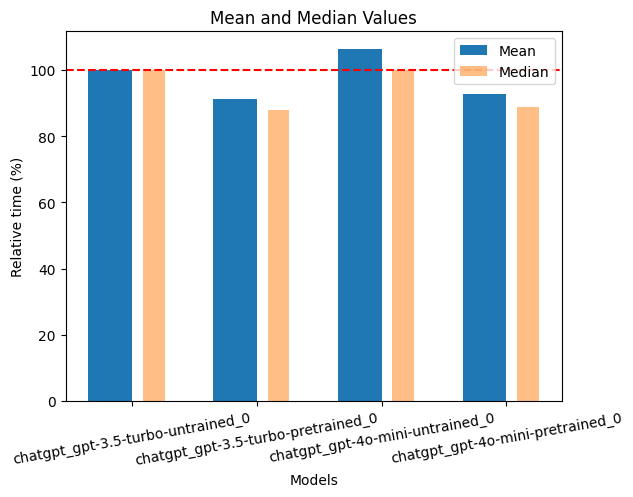

In [293]:
import matplotlib.pyplot as plt
import numpy as np

# Number of bars
num_bars = len(mean)

# Create an array for the x-axis positions
indices = np.arange(num_bars)

# Width of each bar
bar_width = 0.35

# Create the plot
fig, ax = plt.subplots()

# Plot mean bars
ax.bar(indices, mean, bar_width, label='Mean')

# Plot median bars
ax.bar(indices + bar_width, median, bar_width*0.5, label='Median', alpha=0.5)

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Relative time (%)')
ax.set_title('Mean and Median Values')
ax.set_xticks(indices + bar_width / 2)
ax.set_xticklabels(keys[1:])
ax.legend()

ax.axhline(100, color='r', linestyle="--")
plt.xticks(rotation=10)

# Show the plot
plt.show()